# Kickstarter Projects Python Code

In [172]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [173]:
import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# for figures to show up in the notebook:
init_notebook_mode(connected=True) 

In [174]:
np.random.seed(101)

In [175]:
# Set plotting styles
sns.set_style('white')  

In [176]:
# Machine learning libraries:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

----
## Get the data

In [214]:
df = pd.read_csv('ks-projects-201801.csv', encoding="ISO-8859-1")

In [215]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


----
## Data Cleaning

In [216]:
# Drop duplicate data
df = df.drop_duplicates()

In [217]:
df.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [218]:
# Subset the df with all the columns I want.
df = df[['name', 'category', 'main_category', 'launched', 'deadline', 'currency', 
         'usd_goal_real', 'usd_pledged_real', 'backers', 'state']]

In [219]:
# Where are all the NaN values for each column?
df.isnull().sum()

name                4
category            0
main_category       0
launched            0
deadline            0
currency            0
usd_goal_real       0
usd_pledged_real    0
backers             0
state               0
dtype: int64

In [220]:
# Drop the 4 rows that have NaN value in the 'name' column.
df.dropna(inplace=True)

In [221]:
# Rename some columns
df.rename(columns={'usd_goal_real':'goal', 'usd_pledged_real':'pledged'}, inplace=True) 

In [222]:
df.head(2)

,name,category,main_category,launched,deadline,currency,goal,pledged,backers,state
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-08-11 12:12:28,2015-10-09,GBP,1533.95,0.0,0,failed
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-09-02 04:43:57,2017-11-01,USD,30000.00,2421.0,15,failed


In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378657 entries, 0 to 378660
Data columns (total 10 columns):
name             378657 non-null object
category         378657 non-null object
main_category    378657 non-null object
launched         378657 non-null object
deadline         378657 non-null object
currency         378657 non-null object
goal             378657 non-null float64
pledged          378657 non-null float64
backers          378657 non-null int64
state            378657 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 31.8+ MB


In [188]:
df.isnull().sum()

name             0
category         0
main_category    0
launched         0
deadline         0
currency         0
goal             0
pledged          0
backers          0
state            0
dtype: int64

In [224]:
# df['state'] is the target column. 
df['state'].value_counts()

failed        197716
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1845
Name: state, dtype: int64

In [225]:
# Only keep rows of the df that are either 'failed' or 'successful' in the 'state' column.
df = df[(df['state']=='failed') | (df['state']=='successful')]

In [226]:
df['state'].value_counts()

failed        197716
successful    133956
Name: state, dtype: int64

In [227]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 10 columns):
name             331672 non-null object
category         331672 non-null object
main_category    331672 non-null object
launched         331672 non-null object
deadline         331672 non-null object
currency         331672 non-null object
goal             331672 non-null float64
pledged          331672 non-null float64
backers          331672 non-null int64
state            331672 non-null object
dtypes: float64(2), int64(1), object(7)
memory usage: 27.8+ MB


In [228]:
# Change 'launched' column into a DateTime object
df['launched'] =  pd.to_datetime(df['launched'], format='%Y-%m-%d %H:%M:%S')

In [229]:
# Do a feature engineering on the DateTime column to return date only
def feature_1(col):
    date_time = col[0]
    return date_time.date()

In [230]:
# Apply to the 'launched' column
df['launched'] = df[['launched']].apply(feature_1, axis=1)

In [231]:
# Check
type(df['launched'][0])

datetime.date

In [232]:
# Do the same thing with the 'deadline' column
df['deadline'] =  pd.to_datetime(df['deadline'])

In [233]:
df['deadline'] = df[['deadline']].apply(feature_1, axis=1)

In [199]:
# type(df['deadline'][0])

In [200]:
# Compute new column 'days'
df['days'] = df['deadline'] - df['launched']

In [201]:
# Do a feature engineering on the DateTime column to return number of days only.
def feature_2(col):
    date_time = col[0]
    return date_time.days

In [202]:
df['days'] = df[['days']].apply(feature_2, axis=1)

In [203]:
# df['days']

In [204]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 11 columns):
name             331672 non-null object
category         331672 non-null object
main_category    331672 non-null object
launched         331672 non-null object
deadline         331672 non-null object
currency         331672 non-null object
goal             331672 non-null float64
pledged          331672 non-null float64
backers          331672 non-null int64
state            331672 non-null object
days             331672 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 40.4+ MB


In [205]:
df.head()

,name,category,main_category,launched,deadline,currency,goal,pledged,backers,state,days
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-08-11,2015-10-09,GBP,1533.95,0.0,0,failed,59
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-09-02,2017-11-01,USD,30000.00,2421.0,15,failed,60
2,Where is Hank?,Narrative Film,Film & Video,2013-01-12,2013-02-26,USD,45000.00,220.0,3,failed,45
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-03-17,2012-04-16,USD,5000.00,1.0,1,failed,30
5,Monarch Espresso Bar,Restaurants,Food,2016-02-26,2016-04-01,USD,50000.00,52375.0,224,successful,35


----
## Outliers

In [118]:
round(df.describe(), 1)

,goal,pledged,backers,days
count,331672.0,331672.0,331672.0,331672.0
mean,41509.7,9943.5,116.4,34.0
std,1108934.6,96733.4,965.4,12.7
min,0.0,0.0,0.0,1.0
25%,2000.0,50.0,2.0,30.0
50%,5000.0,788.0,15.0,30.0
75%,15000.0,4608.0,63.0,36.0
max,166361390.7,20338986.3,219382.0,92.0


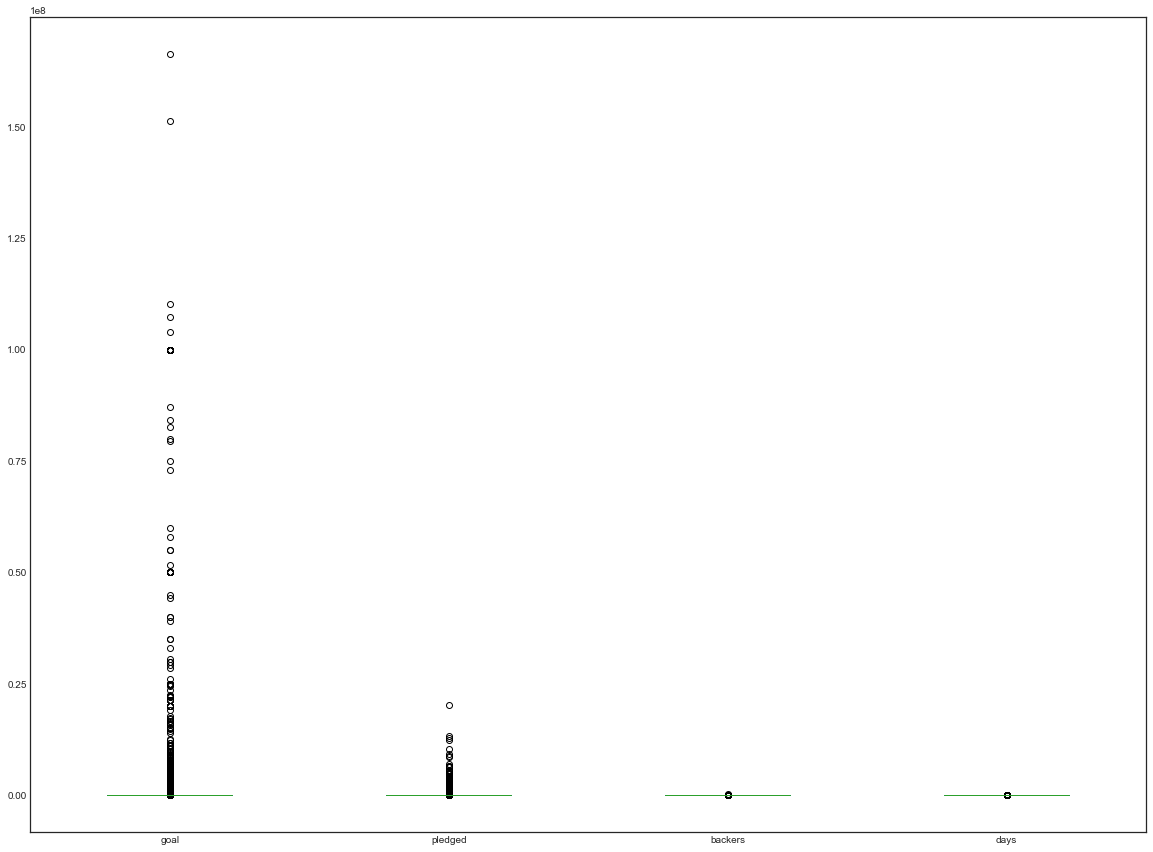

In [119]:
df.plot.box(figsize=(20,15))
 

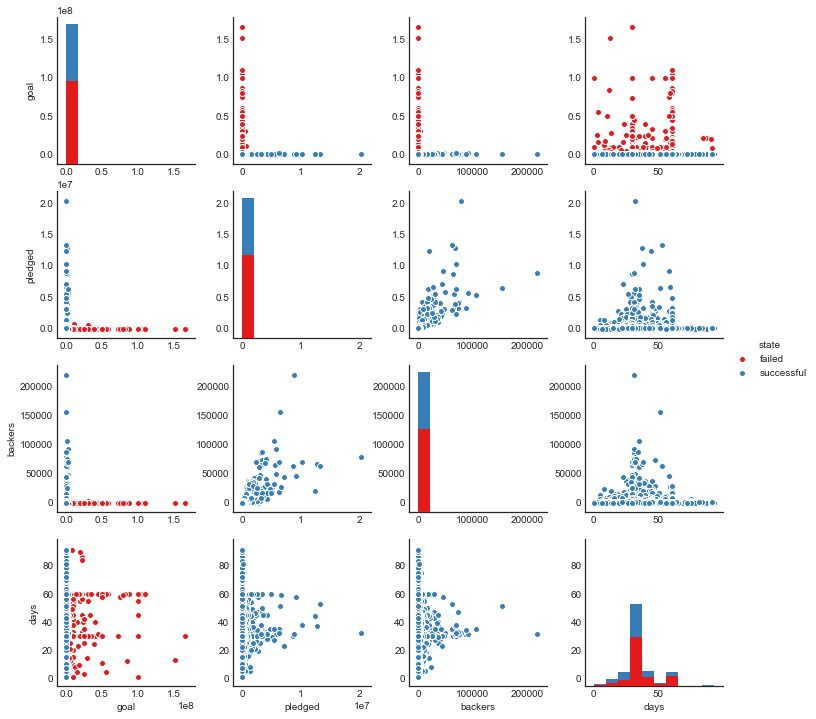

In [120]:
# Do a pairplot on the numberic columns of the data frame
sns.pairplot(df, hue='state', palette='Set1')


In [121]:
# We can see from the pairplot that columns 'goal', 'pledged' and 'backers' are heavily-skewed.

In [39]:
# Make a function to detect outliers with IQR constant being 1000.
def remove_outliers(x, outlier_constant=1000):
    
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    iqr = (upper_quartile - lower_quartile) * outlier_constant
    quartile_set = (lower_quartile - iqr, upper_quartile + iqr)
    outlier_list = []
    
    for y in a.tolist():
        if y < quartile_set[0] or y > quartile_set[1]:
            outlier_list.append(y)
    print(quartile_set)
    print('')
    print(outlier_list)
    return quartile_set

In [40]:
# Check outliers for the 'goal' column
remove_outliers(df.goal)

(-12998000.0, 13015000.0)

[17104542.97, 33000000.0, 100000000.0, 100000000.0, 50000000.0, 73000000.0, 20000000.0, 51647023.58, 166361390.71, 100000000.0, 15000000.0, 21474836.0, 22000000.0, 84300785.2, 100000000.0, 100000000.0, 100000000.0, 50000000.0, 50000000.0, 15000000.0, 87092840.97, 16250000.0, 20000000.0, 55000000.0, 40000000.0, 29242486.89, 44336067.39, 79478620.25, 16000000.0, 21474836.47, 100000000.0, 100000000.0, 25000000.0, 45000000.0, 50000000.0, 14787430.68, 60000000.0, 21474836.0, 35000000.0, 22250000.0, 58000000.0, 151395869.92, 30000000.0, 26000000.0, 20000000.0, 50000000.0, 22327409.13, 75000000.0, 100000000.0, 100000000.0, 100000000.0, 100000000.0, 40000000.0, 107369867.72, 104057189.83, 50000000.0, 15000000.0, 30488734.41, 55000000.0, 82624142.77, 16610000.0, 23564157.35, 35000000.0, 28530019.29, 100000000.0, 100000000.0, 16610000.0, 25000000.0, 25000000.0, 22500000.0, 22000000.0, 14332191.54, 21474836.0, 80000000.0, 100000000.0, 20000000.0, 21474836.47, 19136558.4

(-12998000.0, 13015000.0)

In [41]:
# Check outliers for the 'pledged' column
remove_outliers(df.pledged)

(-4557950.0, 4562608.0)

[5020667.05, 8596474.58, 5545991.7, 6225354.98, 6465690.3, 5764229.38, 5333792.84, 5702153.38, 20338986.27, 5004494.58, 8782571.99, 12779843.49, 13285226.36, 6565782.5, 10266845.74, 12393139.69, 4729263.13, 5408916.95, 9192055.66, 5494492.81, 7072757.0, 4869472.2, 6333295.77]


(-4557950.0, 4562608.0)

In [42]:
# Check outliers for the 'backers' column
remove_outliers(df.backers)

(-60998.0, 61063.0)

[63416, 64867, 85581, 73206, 154926, 63758, 91585, 78471, 87142, 219382, 61290, 70122, 66673, 74405, 62642, 73986, 68929, 105857, 67226, 69320]


(-60998.0, 61063.0)

In [43]:
# Check outliers for the 'day' column
remove_outliers(df.days)

(-5970.0, 6036.0)

[]


(-5970.0, 6036.0)

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 11 columns):
name             331672 non-null object
category         331672 non-null object
main_category    331672 non-null object
launched         331672 non-null object
deadline         331672 non-null object
currency         331672 non-null object
goal             331672 non-null float64
pledged          331672 non-null float64
backers          331672 non-null int64
state            331672 non-null object
days             331672 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 40.4+ MB


In [45]:
# Make a data frame 'df_clean', which is a data frame without all the outliers.
df_clean = df[(df.goal >=-13982925.0) & (df.goal <=14000909.925000001) & 
              (df.pledged >=-4034748.7799999998) & (df.pledged <=4038846.0) &  
              (df.backers >=-54998.0) & (df.backers <=55057.0) &  
              (df.days >=-6970.0) & (df.days <=7037.0)]


In [46]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331535 entries, 0 to 378660
Data columns (total 11 columns):
name             331535 non-null object
category         331535 non-null object
main_category    331535 non-null object
launched         331535 non-null object
deadline         331535 non-null object
currency         331535 non-null object
goal             331535 non-null float64
pledged          331535 non-null float64
backers          331535 non-null int64
state            331535 non-null object
days             331535 non-null int64
dtypes: float64(2), int64(2), object(7)
memory usage: 30.4+ MB


In [47]:
df_clean.describe()

,goal,pledged,backers,days
count,3.315350e+05,3.315350e+05,331535.000000,331535.000000
mean,2.582588e+04,9.257038e+03,110.019832,33.951411
std,1.974991e+05,5.990962e+04,611.632078,12.709917
min,1.000000e-02,0.000000e+00,0.000000,1.000000
25%,2.000000e+03,5.000000e+01,2.000000,30.000000
50%,5.000000e+03,7.890000e+02,15.000000,30.000000
75%,1.500000e+04,4.607000e+03,63.000000,36.000000
max,1.264302e+07,3.999796e+06,46520.000000,92.000000


In [ ]:
# Since columns 'goal', 'pledged' and 'backers' are heavily-skewed, I decide to include the outliers 
# in my following data exploration and analysis.

----
## Exploratory Data Analysis

#### Step 1: Overall Data Visualization

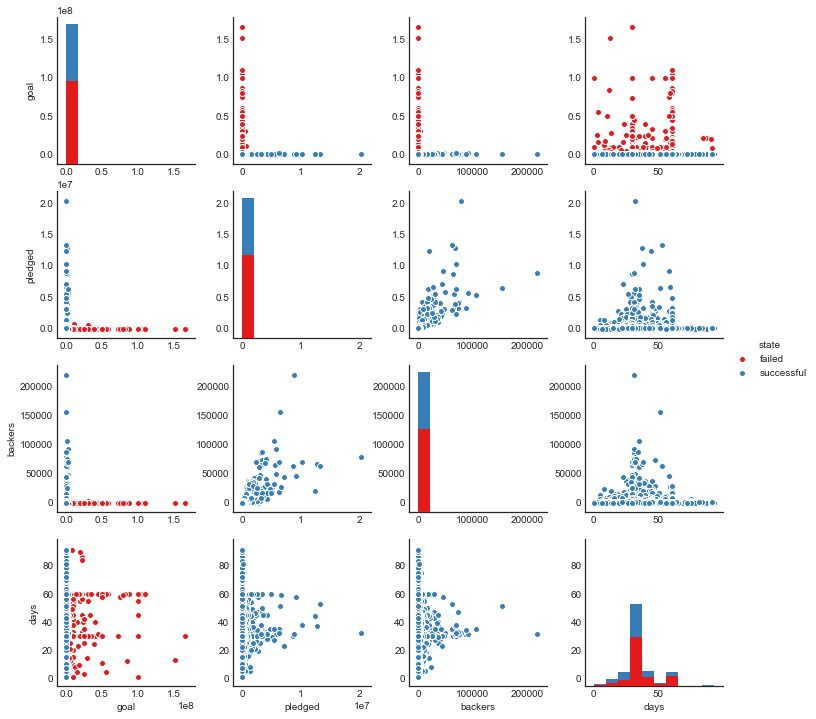

In [122]:
sns.pairplot(df, hue='state', palette='Set1')


In [70]:
# Some comments about the pairplot.
# heavily-skewed data for columns 'goal', 'pledged', 'backers'. 
# So when I do exploratory analysis on these columns, best to use median instead of mean.

In [127]:
# Make a correlation heatmap
df_drop = df.drop('state', axis = 1) 
df_corr = df_drop.corr()
df_corr

,goal,pledged,backers,days
goal,1.000000,0.006354,0.005208,0.021606
pledged,0.006354,1.000000,0.752291,0.008652
backers,0.005208,0.752291,1.000000,-0.000049
days,0.021606,0.008652,-0.000049,1.000000


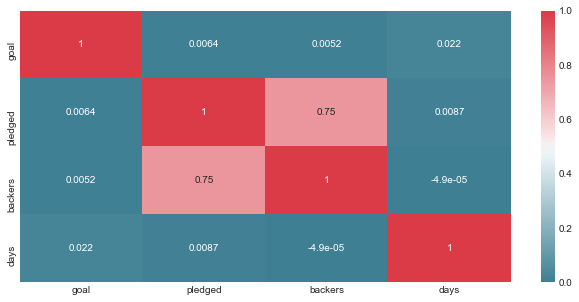

In [128]:
# Set up the matplotlib figure:
f, ax = plt.subplots(figsize=(11, 5))

# Generate a custom diverging colormap:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df_corr, annot=True, cmap=cmap, xticklabels=df_corr.columns, yticklabels=df_corr.columns)


In [ ]:
# Some comments about the heatmap:
# Columns 'pledged' and 'backers' have a strong positive correlation, which is not surprising.
# Pairings such as 'goal' and 'pledged', 'goal' and 'backers' have approximately zero correlation.
# column 'days' have approximately zero correlation with columns 'goal' and 'pledged', 
# but a negative correlation with column 'backers'.

----
#### Step 2: Failed v.s Successful Visualizations

Text(0.5,1,'Failed v.s Successful Kickstarter Projects')

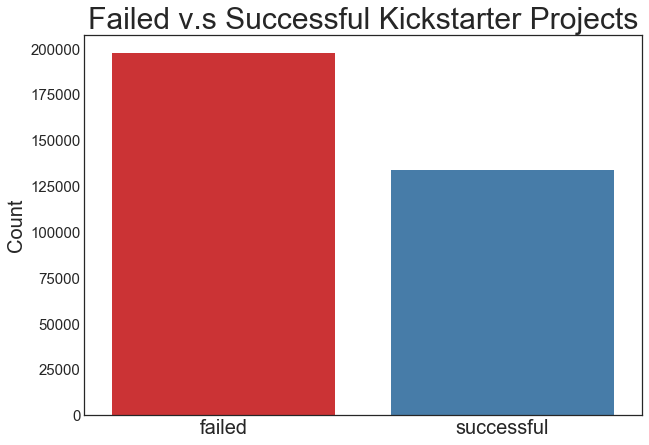

In [135]:
# Number of Failed and Successful Kickstarter Projects
plt.figure(figsize=(10,7))
sns.countplot(df['state'], palette='Set1')
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Count', fontsize=20)
plt.title('Failed v.s Successful Kickstarter Projects', fontsize=30)

Text(0.5,1,'Failed v.s Successful Kickstarter Projects by Currency')

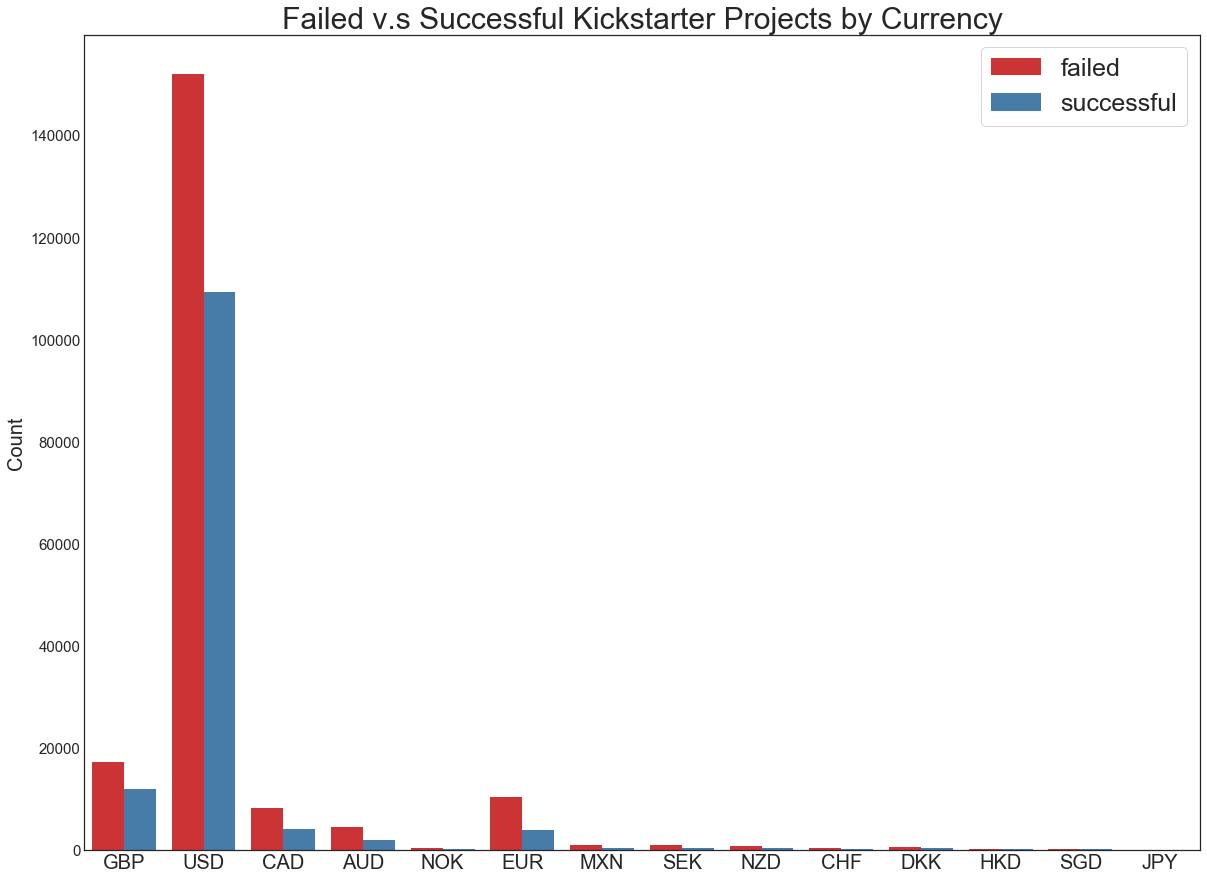

In [170]:
# Number of Failed and Successful Kickstarter Projects by Currency
plt.figure(figsize=(20,15))
sns.countplot('currency', hue='state', dodge=True, data=df, palette='Set1')
plt.legend(loc='best', frameon=True, fontsize=25)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Count', fontsize=20)
plt.title('Failed v.s Successful Kickstarter Projects by Currency', fontsize=30)


In [53]:
df_state_median = df.groupby('state')[['goal', 'pledged', 'backers', 'days']].median().reset_index()
df_state_median

,state,goal,pledged,backers,days
0,failed,7500.00,100.00,3,30
1,successful,3837.74,5107.25,71,30


Text(0.5,1,'Failed v.s Successful Kickstarter Projects by Median Goal and Pledged Amounts')

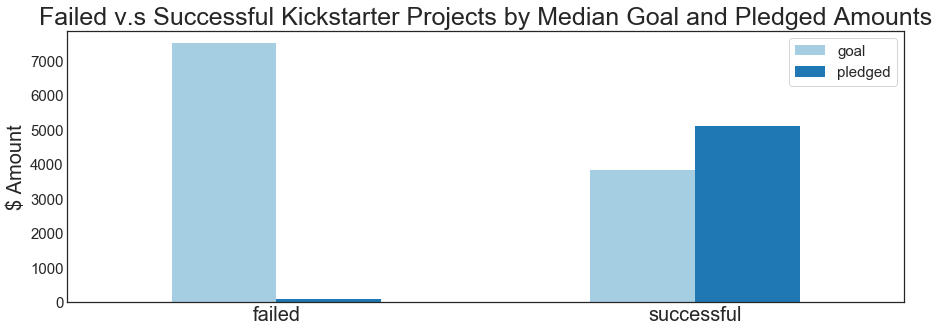

In [159]:
# Failed v.s Successful Kickstarter Projects by Median Goal and Pledged Amounts
df_state_median.plot.bar(x='state', y=['goal', 'pledged'], stacked=False, figsize=(15,5), 
                         color=sns.color_palette('Paired'))
plt.legend(loc='best', frameon=True, fontsize=15)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('$ Amount', fontsize=20)
plt.title('Failed v.s Successful Kickstarter Projects by Median Goal and Pledged Amounts', fontsize=25)


Text(0.5,1,'Failed v.s Successful Kickstarter Projects by Median Number of Backers')

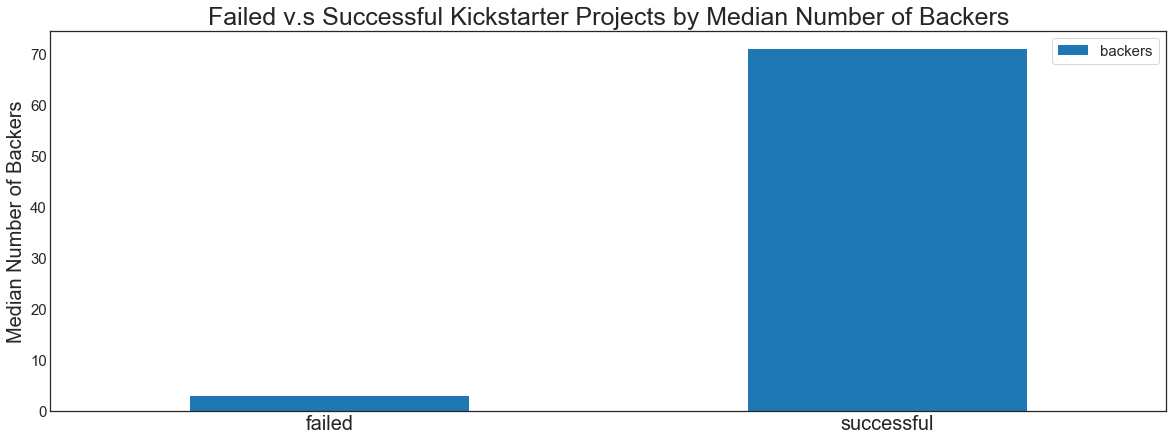

In [161]:
# Failed v.s Successful Kickstarter Projects by Median Number of Backers
df_state_median.plot.bar(x='state', y='backers', stacked=True, figsize=(20,7))
plt.legend(loc='best', frameon=True, fontsize=15)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('')
plt.ylabel('Median Number of Backers', fontsize=20)
plt.title('Failed v.s Successful Kickstarter Projects by Median Number of Backers', fontsize=25)


----
#### Step 3: Visualizations by Categories

Text(0.5,1,'Failed v.s Successful Kickstarter Projects by Category')

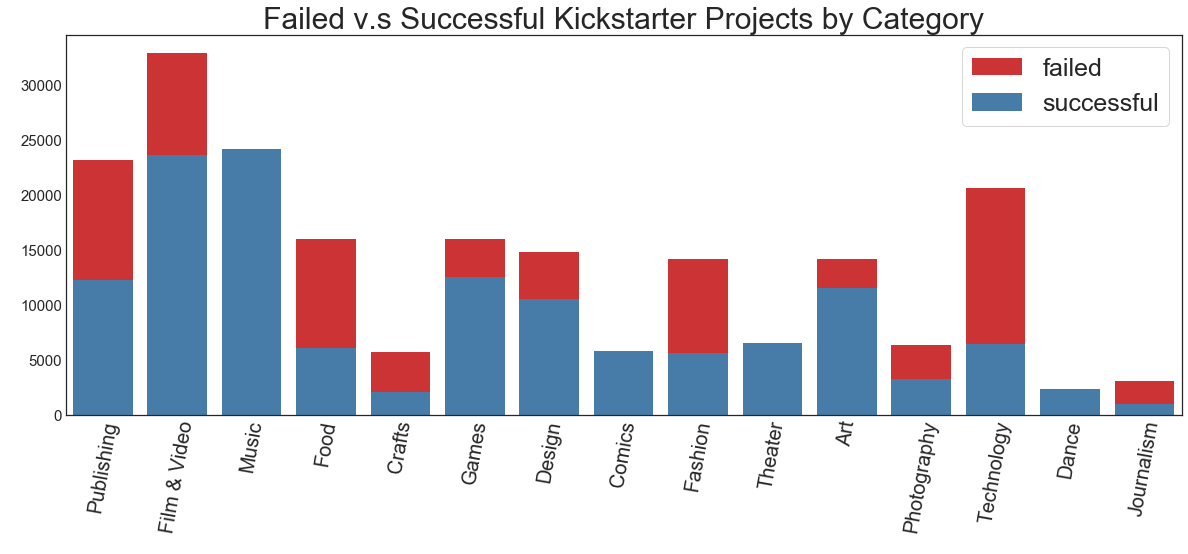

In [137]:
# Number of Failed and Successful Kickstarter Projects by Category
plt.figure(figsize=(20,7))
sns.countplot('main_category', hue='state', dodge=False, data=df, palette='Set1')
plt.legend(loc='best', frameon=True, fontsize=25)
plt.xticks(rotation=80, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel(' ')
plt.ylabel('Count', fontsize=20)
plt.title('Failed v.s Successful Kickstarter Projects by Category', fontsize=30)

In [162]:
df_category_median = df.groupby('main_category')[['goal', 'pledged', 'backers', 'days']].median().reset_index()
df_category_median


,main_category,goal,pledged,backers,days
0,Art,2963.845,537.00,12,30
1,Comics,3500.000,1735.00,46,30
2,Crafts,2176.060,109.63,4,30
3,Dance,3200.000,2040.00,29,30
4,Design,10000.000,2279.00,34,30
5,Fashion,5500.000,293.89,6,30
6,Film & Video,6400.000,963.84,15,30
7,Food,10000.000,323.00,7,30
8,Games,7500.000,1743.00,40,30
9,Journalism,5000.000,75.00,3,30


Text(0.5,1,'Goal v.s Pledged Median Amount by Category')

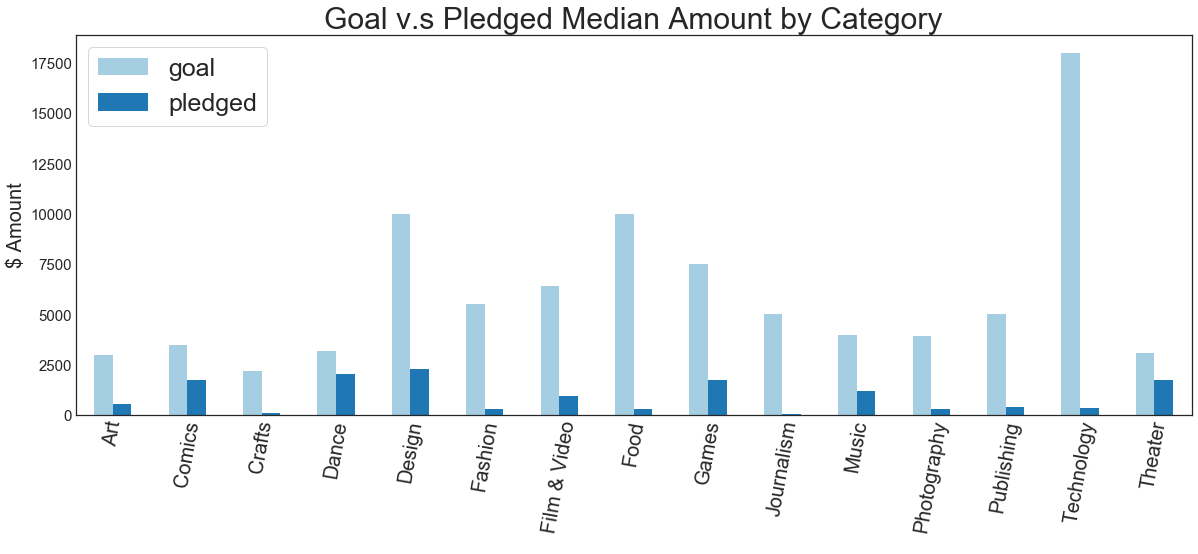

In [164]:
# Goal v.s Pledged Median Amount by Category
df_category_median.plot.bar(x='main_category', y=['goal', 'pledged'], stacked=False, 
                     color=sns.color_palette('Paired'), figsize=(20,7))
plt.legend(loc='best', frameon=True, fontsize=25)
plt.xticks(rotation=80, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel(' ')
plt.ylabel('$ Amount', fontsize=20)
plt.title('Goal v.s Pledged Median Amount by Category', fontsize=30)

Text(0.5,1,'Median Number of Backers by Category')

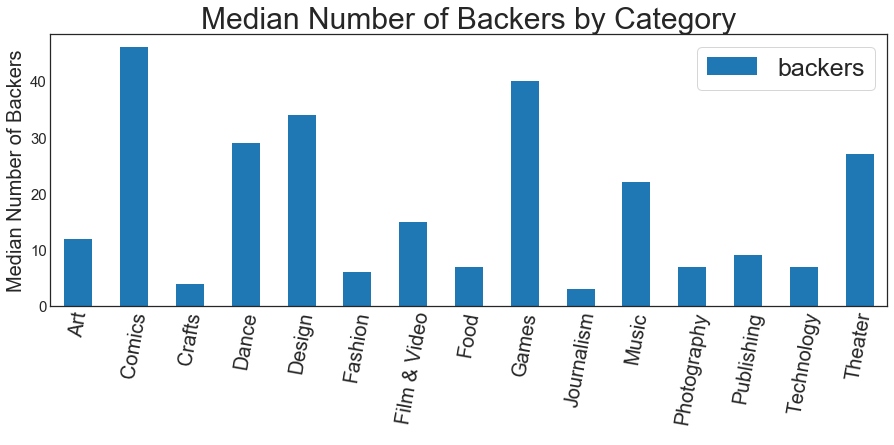

In [169]:
# Median Number of Backers by Category
df_category_median.plot.bar(x='main_category', y='backers', figsize=(15,5))
plt.legend(loc='best', frameon=True, fontsize=25)
plt.xticks(rotation=80, fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel(' ')
plt.ylabel('Median Number of Backers', fontsize=20)
plt.title('Median Number of Backers by Category', fontsize=30)


----
## Machine Learning

Use Random Forest to do feature selections and also use Random Forest to predict 
whether a kickstarter project will succeed or fail.


In [234]:
# Change 'successful' to '1' and 'failed' to '0'
# Use Broadcasting
df.loc[df['state']=='successful', 'state'] = 1
df.loc[df['state']=='failed', 'state'] = 0

In [235]:
# Change the 'state' column's data type to integer
df['state'] = df['state'].astype(int)

In [236]:
dfm1 = df.drop(['name', 'main_category', 'launched', 'deadline'], axis=1)

In [237]:
dfm1.isnull().sum()

category    0
currency    0
goal        0
pledged     0
backers     0
state       0
dtype: int64

In [795]:
corr = dfm1.corr()

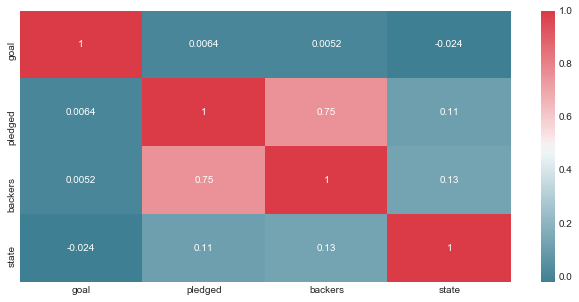

In [682]:
# Make a correlation heatmap

# Set up the matplotlib figure:
f, ax = plt.subplots(figsize=(11, 5))

# Generate a custom diverging colormap:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap, xticklabels=corr.columns, yticklabels=corr.columns)


In [683]:
# In theory, multicollinearity is not a problem for Random Forest.

In [238]:
# Make dummy variables
category_dum = pd.get_dummies(dfm1['category'], drop_first=True)
currency_dum = pd.get_dummies(dfm1['currency'], drop_first=True)

In [239]:
dfm1.drop(['category','currency'], axis=1, inplace=True)

In [240]:
dfm2 = pd.concat([dfm1, category_dum, currency_dum], axis=1)

In [241]:
dfm2.head()

,goal,pledged,backers,state,Academic,Accessories,Action,Animals,Animation,Anthologies,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,1533.95,0.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.00,2421.0,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.00,220.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.00,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.00,52375.0,224,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [242]:
# Features
X = dfm2.drop('state', axis=1)
X.head()

,goal,pledged,backers,Academic,Accessories,Action,Animals,Animation,Anthologies,Apparel,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
0,1533.95,0.0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,30000.00,2421.0,15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,45000.00,220.0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5000.00,1.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,50000.00,52375.0,224,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [243]:
# Target
y = dfm2['state']
y.head()

0    0
1    0
2    0
3    0
5    1
Name: state, dtype: int64

In [244]:
y.value_counts()

0    197716
1    133956
Name: state, dtype: int64

In [830]:
# Make a pipeline
pipe = make_pipeline(RandomForestClassifier(random_state=101)) 
pipe

Pipeline(memory=None,
     steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False))])

In [831]:
# Compute predicted y's (y_hat)
predicted = cross_val_predict(pipe, X, y, cv=3, n_jobs=-1)
predicted

array([0, 0, 0, ..., 0, 0, 0])

In [832]:
# Classification table
print(classification_report(y, predicted))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99    197716
          1       0.99      0.99      0.99    133956

avg / total       0.99      0.99      0.99    331672



In [833]:
# Confusion table
print(confusion_matrix(y, predicted))

[[196214   1502]
 [   741 133215]]


In [435]:
# Are all the features important for making the prediction?
# Use Random Forest to evaluate the importance of features on the classification task.
names = X.columns
rf = RandomForestClassifier()
rf.fit(X, y)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.33779999999999999, 'backers'), (0.33460000000000001, 'pledged'), (0.25990000000000002, 'goal'), (0.0206, 'days'), (0.0040000000000000001, 'Product Design'), (0.0030999999999999999, 'Video Games'), (0.0022000000000000001, 'Shorts'), (0.0020999999999999999, 'Tabletop Games'), (0.0016000000000000001, 'Technology'), (0.0016000000000000001, 'Indie Rock'), (0.0015, 'USD'), (0.0012999999999999999, 'Music'), (0.0011999999999999999, 'Country & Folk'), (0.0011000000000000001, 'EUR'), (0.0011000000000000001, 'Apps'), (0.001, 'Theater'), (0.001, 'GBP'), (0.00080000000000000004, 'Rock'), (0.00080000000000000004, 'Hardware'), (0.00080000000000000004, 'Gadgets'), (0.00080000000000000004, 'CAD'), (0.00069999999999999999, 'Food'), (0.00059999999999999995, 'Playing Cards'), (0.00059999999999999995, 'Documentary'), (0.00059999999999999995, 'Art'), (0.00059999999999999995, 'Apparel'), (0.00050000000000000001, 'Illustration'), (0.00050000000000000001, 'Dance'), (0.000500

In [834]:
# Use only the first four most important features from the feature selection
 
dfm3 = dfm2[['backers', 'pledged', 'goal', 'days', 'state']]
dfm3.head()

,backers,pledged,goal,days,state
0,0,0.0,1533.95,59,0
1,15,2421.0,30000.00,60,0
2,3,220.0,45000.00,45,0
3,1,1.0,5000.00,30,0
5,224,52375.0,50000.00,35,1


In [835]:
# Features
X_3 = dfm3.drop('state', axis=1)
X_3.head()

,backers,pledged,goal,days
0,0,0.0,1533.95,59
1,15,2421.0,30000.00,60
2,3,220.0,45000.00,45
3,1,1.0,5000.00,30
5,224,52375.0,50000.00,35


In [836]:
# Target
y_3 = dfm3['state']
y_3.head()

0    0
1    0
2    0
3    0
5    1
Name: state, dtype: int64

In [837]:
# Make a pipeline
pipe_3 = make_pipeline(RandomForestClassifier(random_state=101)) 
pipe_3

Pipeline(memory=None,
     steps=[('randomforestclassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=101, verbose=0, warm_start=False))])

In [838]:
# Compute predicted y's (y_hat)
predicted_3 = cross_val_predict(pipe_3, X_3, y_3, cv=3, n_jobs=-1)
predicted_3

array([0, 0, 0, ..., 0, 0, 0])

In [839]:
# Classification table
print(classification_report(y_3, predicted_3))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    197716
          1       1.00      1.00      1.00    133956

avg / total       1.00      1.00      1.00    331672



In [840]:
# Confusion table
print(confusion_matrix(y_3, predicted_3))

[[197462    254]
 [    40 133916]]


In [ ]:
# Both precision and recall rates increased to 1 after doing the feature selection.

----
## Text Classification using NLP with Naive Bayes and Random Forest

The original dataset has a text-based column called 'name'.

Can I predict if a Kickstarter project will succeed or fail solely based on this 'name' column?

I will use NLP to convert text-based data into a numeric matrix, then use Naive Bayes classification
and Random Forest classification to do the predictions.

In [443]:
df.head()

,name,category,main_category,launched,deadline,currency,goal,pledged,backers,state,days
0,The Songs of Adelaide & Abullah,Poetry,Publishing,2015-08-11,2015-10-09,GBP,1533.95,0.0,0,0,59
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,2017-09-02,2017-11-01,USD,30000.00,2421.0,15,0,60
2,Where is Hank?,Narrative Film,Film & Video,2013-01-12,2013-02-26,USD,45000.00,220.0,3,0,45
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,2012-03-17,2012-04-16,USD,5000.00,1.0,1,0,30
4,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,2015-07-04,2015-08-29,USD,19500.00,1283.0,14,0,56


In [841]:
dfn = df[['name', 'state']]
dfn.head()

,name,state
0,The Songs of Adelaide & Abullah,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,0
2,Where is Hank?,0
3,ToshiCapital Rekordz Needs Help to Complete Album,0
5,Monarch Espresso Bar,1


In [842]:
# features:
X_n1 = dfn['name']

In [843]:
# target:
y_n1 = dfn['state']

In [844]:
# Use Naive Bayes classification
pipe3 = make_pipeline(TfidfVectorizer(stop_words='english'), MultinomialNB())  
pipe3

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...   vocabulary=None)), ('multinomialnb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [459]:
predicted3 = cross_val_predict(pipe3, X_n1, y_n1, cv=3, n_jobs=-1)

In [460]:
# Classification table:
print(classification_report(y_n1, predicted3))

             precision    recall  f1-score   support

          0       0.67      0.94      0.78    238340
          1       0.64      0.18      0.29    133956

avg / total       0.66      0.67      0.61    372296



In [468]:
# Use Random Forest classification
pipe4 = make_pipeline(TfidfVectorizer(stop_words='english'), RandomForestClassifier())  
pipe4

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [473]:
# Too computationally expensive to compute predictions with the cross-validation method.
# predicted4 = cross_val_predict(pipe4, X_n1, y_n1, cv=3, n_jobs=-1)

In [474]:
# So, I changed to a train-test split method to compute the predictions.
X_train, X_test, y_train, y_test = train_test_split(X_n1, y_n1, test_size=0.3, random_state=101)

In [475]:
pipe4.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidfvectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_i...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [476]:
predicted4 = pipe4.predict(X_test)

In [478]:
# classification table:
print(classification_report(y_test, predicted4))

             precision    recall  f1-score   support

          0       0.69      0.84      0.76     71645
          1       0.55      0.34      0.42     40044

avg / total       0.64      0.66      0.64    111689



In [ ]:
# As expected, predicting whether a Kickstarter project will succeed or fail solely based on 
# the 'name' column does not have as good a prediction power compared to what we've done eariler 
# with other columns.

----
## Recommendations for Investing in a New Project

My client is interested in investing in some kickstarter projects in the Film & video category. 
He wants some recommendations on which project he should invest in.

In [960]:
dfr = pd.read_csv('ks-projects-201801.csv', encoding="ISO-8859-1")

In [961]:
# Subset the df with all the columns I want.
dfr = dfr[['name', 'category', 'main_category',  
         'usd_goal_real', 'usd_pledged_real', 
         'backers', 'state']]

In [969]:
# Subset the data frame to 'Film & Video' only
dfr = dfr[dfr.main_category=='Film & Video']

In [970]:
# Drop duplicate data
dfr = dfr.drop_duplicates()

In [971]:
# Drop NaN values
dfr.dropna(inplace=True)

In [972]:
dfr.rename(columns={'usd_goal_real':'goal', 'usd_pledged_real':'pledged'}, inplace=True) 

In [973]:
# Add a column 'surplus'
dfr['surplus'] =  dfr['pledged'] - dfr['goal'] 
dfr['surplus'].head()

1    -27579.00
2    -44780.00
4    -18217.00
9    -58759.43
27    26860.99
Name: surplus, dtype: float64

In [974]:
# Subset the data frame to 'live' projects only (projects that people can still invest in)
dfr_live = dfr[dfr.state=='live']
dfr_live.head()

,name,category,main_category,goal,pledged,backers,state,surplus
183,KILOS.,Thrillers,Film & Video,5000.00,310.00,4,live,-4690.00
458,The Man in the Field,Horror,Film & Video,1159.38,563.32,11,live,-596.06
537,Dear Atlantas,Film & Video,Film & Video,2000.00,5.00,1,live,-1995.00
752,Durango Falls TV Show,Film & Video,Film & Video,10000.00,1.00,1,live,-9999.00
1920,MORE BIKE LIFE,Documentary,Film & Video,18372.07,0.00,0,live,-18372.07


In [977]:
# Sort 'live' projects by 'surplus' and 'backers'
dfr_sort = dfr_live.sort_values(by=['surplus', 'backers'], axis=0, ascending=False, na_position='first') 
dfr_sort.head(20)

,name,category,main_category,goal,pledged,backers,state,surplus
319442,MADE YOU LOOK,Shorts,Film & Video,3500.00,6204.00,81,live,2704.00
242907,The Whibbits! A stop motion animated web serie...,Animation,Film & Video,818.39,2482.44,30,live,1664.05
190837,LaVoy: Dead Man Talking,Documentary,Film & Video,12000.00,13450.00,125,live,1450.00
341218,CADABRA - A Short Film,Comedy,Film & Video,406.55,1599.09,7,live,1192.54
127730,The Walk,Film & Video,Film & Video,6775.80,7479.13,73,live,703.33
132682,"""BRIDGES"" a short doc about the in-betweeners",Documentary,Film & Video,7000.00,7656.00,56,live,656.00
314947,Lady (short film),Shorts,Film & Video,1295.78,1853.65,36,live,557.87
127532,Code Switch,Horror,Film & Video,3000.00,3511.00,27,live,511.00
246730,FATHOM | an Eco-Thriller,Shorts,Film & Video,6000.00,6452.00,35,live,452.00
43336,BEAT IT,Shorts,Film & Video,1355.16,1775.26,20,live,420.10


In [ ]:
# Obviously, my client should invest in projects that are already successful, i.e. live projects 
# that the pledged amount >= goal amount